# Exoplanet Prediction Modeling

Over a period of nine years in deep space, the NASA Kepler space telescope has been out on a planet-hunting mission to discover hidden planets outside of our solar system.

Below are several machine learning models capable of classifying candidate exoplanets from the raw dataset

Data from [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi)

In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in /opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages (0.0)


In [2]:
# install joblib for saving
# Restart kernel after installing 
!pip install joblib

In [3]:
import pandas as pd
from pprint import pprint
import numpy as np

## Exploring and Selecting the Data

This dataset is a cumulative record of all observed Kepler "objects of interest" and contains an extensive data directory. 

**Exoplanet Achive Information**: The disposition or label in the literature for the exoplanet candidate. One of CANDIDATE, FALSE POSITIVE, NOT DISPOSITIONED or CONFIRMED. (**koi_disposition**)

**Project Disposition Columns**: NASA flags used to identify or assign the foreign body. Labeled with _flag_ and not useful for generating a model.

**Transit Properties**: Calculated parameters of the object such as  Orbital Period, Transit Epoch, Planet-Star Radius Ratio, Planet-Star Distance over Star Radius and Impact Parameter. _Transit properties contain uncertainty values and are identified with a suffix _err. The margin of error is NOT included in the model_

**Stellar Parameters**: Stellar parameters are observational data used to determine stellar physics. These include effective temperature, surface gravity, metallicity, radius, mass, and ageCalculated parameters of the object such as  Orbital Period, Transit Epoch, Planet-Star Radius Ratio, Planet-Star Distance over Star Radius and Impact Parameter. _Stellar properties contain uncertainty values and are identified with a suffix _err. The margin of error is NOT included in the model_

**KIC Parameters**: Physical properties and target identifier.

[Full Directory of Data Columns Definitions](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)


### Read the CSV and Perform Basic Data Cleaning

In [4]:
df = pd.read_csv("exoplanet_data.csv")

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()
df.columns

Index(['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec',
       'koi_kepmag'],
      dtype='object')

In [5]:
# Removing unwanted columns from dataset
exo_df = df[['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact','koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol','koi_model_snr', 'koi_steff', 'koi_srad','ra', 'dec',
       'koi_kepmag']]
exo_df.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_srad,ra,dec,koi_kepmag
0,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443,9.11,25.8,5455,0.927,291.93423,48.141651,15.347
1,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638,39.30,76.3,5853,0.868,297.00482,48.134129,15.436
2,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395,891.96,505.6,5805,0.791,285.53461,48.285210,15.597
3,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406,926.16,40.9,6031,1.046,288.75488,48.226200,15.509
4,0,0,0,0,4.134435,172.979370,0.762,3.14020,686.0,2.77,1160,427.65,40.2,6046,0.972,296.28613,48.224670,15.714


In [6]:
# Find the classifiers for the koi_disposition
df["koi_disposition"].unique()

array(['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE'], dtype=object)

# Preprocessing the Data

### Assign X(features) and y (target) from the data

In [7]:
X = exo_df
y = df["koi_disposition"]
print(X.shape, y.shape)

(6991, 18) (6991,)


### Split the data into testing and training

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_srad,ra,dec,koi_kepmag
6122,0,0,0,0,6.768901,133.077240,0.150,3.61600,123.1,1.24,1017,253.30,10.8,5737,1.125,294.40472,39.351681,14.725
6370,0,1,0,1,0.733726,132.020050,0.291,2.30900,114.6,0.86,1867,2891.64,13.8,5855,0.797,284.50391,42.463860,15.770
2879,1,0,0,0,7.652707,134.460380,0.970,79.89690,641.1,3.21,989,226.81,254.3,6328,0.963,295.50211,38.983540,13.099
107,0,0,0,0,7.953547,174.662240,0.300,2.63120,875.4,2.25,696,55.37,38.4,4768,0.779,291.15878,40.750271,15.660
29,0,0,0,0,4.959319,172.258529,0.831,2.22739,9802.0,12.21,1103,349.40,696.5,5712,1.082,292.16705,48.727589,15.263


### MinMaxScalar to fit and transform X features

In [9]:
#Fit Transform using MinMaxScalar for X features
from sklearn.preprocessing import MinMaxScaler
X_minmax = MinMaxScaler().fit(X_train)

X_train_minmax = X_minmax.transform(X_train)
X_test_minmax = X_minmax.transform(X_test)

### Label Encoding for target (y) value (neural networks)

In [10]:
# Visualize Label Encoding
from sklearn.preprocessing import LabelEncoder
disposition_types = ('CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE')
disposition_df = pd.DataFrame(disposition_types, columns=['disposition_types'])# converting type of columns to 'category'

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
disposition_df['disposition_types_cat'] = labelencoder.fit_transform(disposition_df['disposition_types'])
disposition_df

,disposition_types,disposition_types_cat
0,CANDIDATE,0
1,CONFIRMED,1
2,FALSE POSITIVE,2


In [11]:
# Perform Label encoding on train and test data set for y
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [12]:
# Create one-hot encoding for neural network
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

# Support Vector Machine Classifiers: Linear
-----

In [14]:
# Create the SVC Model
from sklearn.svm import SVC 
model_SVC = SVC(kernel='linear')
model_SVC.fit(X_train_minmax, y_train)

print(f"Training Data Score: {model_SVC.score(X_train_minmax, y_train)}")
print(f"Testing Data Score: {model_SVC.score(X_test_minmax, y_test)}")

Training Data Score: 0.8085065802021744
Testing Data Score: 0.7980549199084668


## Hypertune SVM using GridSearch CV

In [15]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model_SVC, param_grid, verbose=3)

In [16]:
# Fit the Model using the grid search estimator
grid.fit(X_train_minmax, encoded_y_train)
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.819, total=   0.1s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................... C=1, gamma=0.0001, score=0.803, total=   0.1s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.807, total=   0.1s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ................... C=1, gamma=0.0001, score=0.782, total=   0.1s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.807, total=   0.1s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.819, total=   0.1s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.803, total=   0.1s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.807, total=   0.1s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.782, total=   0.1s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.807, total=   0.1s
[CV] C=1, gamma=0.001 ................................................
[CV] .

[CV] .................. C=50, gamma=0.0001, score=0.809, total=   0.2s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.816, total=   0.2s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.807, total=   0.2s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.821, total=   0.2s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .................. C=50, gamma=0.0005, score=0.845, total=   0.2s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .................. C=50, gamma=0.0005, score=0.809, total=   0.2s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .................. C=50, gamma=0.0005, score=0.816, total=   0.2s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   13.3s finished


{'C': 50, 'gamma': 0.0001}


In [17]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best SVG score: {grid.best_score_}")

Best Parameters: {'C': 50, 'gamma': 0.0001}
Best SVG score: 0.8195667993508904


### Create and Fit Hypertune SVM

In [18]:
model_SVC2 = SVC(C=50, gamma= 0.0001, kernel='linear')
model_SVC2.fit(X_train_minmax, encoded_y_train)
print(f"Training Data Score: {model_SVC2.score(X_train_minmax, encoded_y_train)}")
print(f"Testing Data Score: {model_SVC2.score(X_test_minmax, encoded_y_test)}")

Training Data Score: 0.8241464810223155
Testing Data Score: 0.8100686498855835


### Save the Model

In [19]:
import joblib
filename = 'Models/lmstein_svm.sav'
joblib.dump("lmstein", filename)

['Models/lmstein_svm.sav']

# Logistic Regression
-----

In [20]:
import matplotlib.pyplot as plt

#Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Fit the model to the data
classifier.fit(X_train_minmax, y_train)


# Scoer the model
print(f"Training Data Score: {classifier.score(X_train_minmax, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_minmax, y_test)}")

Training Data Score: 0.8136563036429525
Testing Data Score: 0.8037757437070938


## Hypertune the Model

In [21]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
params = {"C": [1,2,10], 'penalty': ['l1', 'l2']}
grid2 =GridSearchCV(classifier,params,verbose=3)
grid2.fit(X_train_minmax, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=1, penalty=l1 .................................................
[CV] ....................... C=1, penalty=l1, score=nan, total=   0.0s
[CV] C=1, penalty=l1 .................................................
[CV] ....................... C=1, penalty=l1, score=nan, total=   0.0s
[CV] C=1, penalty=l1 .................................................
[CV] ....................... C=1, penalty=l1, score=nan, total=   0.0s
[CV] C=1, penalty=l1 .................................................
[CV] ....................... C=1, penalty=l1, score=nan, total=   0.0s
[CV] C=1, penalty=l1 .................................................
[CV] ....................... C=1, penalty=l1, score=nan, total=   0.0s
[CV] C=1, penalty=l2 .................................................
[CV] ..................... C=1, penalty=l2, score=0.828, total=   0.1s
[CV] C=1, penalty=l2 .................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
[Paralle

[CV] ..................... C=1, penalty=l2, score=0.815, total=   0.1s
[CV] C=1, penalty=l2 .................................................
[CV] ..................... C=1, penalty=l2, score=0.797, total=   0.1s
[CV] C=1, penalty=l2 .................................................
[CV] ..................... C=1, penalty=l2, score=0.806, total=   0.1s
[CV] C=2, penalty=l1 .................................................
[CV] ....................... C=2, penalty=l1, score=nan, total=   0.0s
[CV] C=2, penalty=l1 .................................................
[CV] ....................... C=2, penalty=l1, score=nan, total=   0.0s
[CV] C=2, penalty=l1 .................................................
[CV] ....................... C=2, penalty=l1, score=nan, total=   0.0s
[CV] C=2, penalty=l1 .................................................
[CV] ....................... C=2, penalty=l1, score=nan, total=   0.0s
[CV] C=2, penalty=l1 .................................................
[CV] .

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV] ..................... C=2, penalty=l2, score=0.830, total=   0.1s
[CV] C=2, penalty=l2 .................................................
[CV] ..................... C=2, penalty=l2, score=0.803, total=   0.1s
[CV] C=2, penalty=l2 .................................................
[CV] ..................... C=2, penalty=l2, score=0.816, total=   0.1s
[CV] C=2, penalty=l2 .................................................
[CV] ..................... C=2, penalty=l2, score=0.800, total=   0.1s
[CV] C=2, penalty=l2 .................................................
[CV] ..................... C=2, penalty=l2, score=0.814, total=   0.1s
[CV] C=10, penalty=l1 ................................................
[CV] ...................... C=10, penalty=l1, score=nan, total=   0.0s
[CV] C=10, penalty=l1 ................................................
[CV] ...................... C=10, penalty=l1, score=nan, total=   0.0s
[CV] C=10, penalty=l1 ................................................
[CV] .

/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.

[CV] .................... C=10, penalty=l2, score=0.844, total=   0.1s
[CV] C=10, penalty=l2 ................................................
[CV] .................... C=10, penalty=l2, score=0.810, total=   0.1s
[CV] C=10, penalty=l2 ................................................


/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

[CV] .................... C=10, penalty=l2, score=0.811, total=   0.1s
[CV] C=10, penalty=l2 ................................................
[CV] .................... C=10, penalty=l2, score=0.804, total=   0.1s
[CV] C=10, penalty=l2 ................................................
[CV] .................... C=10, penalty=l2, score=0.822, total=   0.1s


/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 2, 10], 'penalty': ['l1', 'l2']}, verbose=3)

In [22]:
print(f"Best Parameters: {grid2.best_params_}")
print(f"Best SVG score: {grid2.best_score_}")

Best Parameters: {'C': 10, 'penalty': 'l2'}
Best SVG score: 0.8182318311150569


### Create and Fit Hypertuned Logistic Regression

In [23]:
classifier2 = LogisticRegression(C=10, penalty="l2")

# Fit the model to the data
classifier2.fit(X_train_minmax, y_train)

print(f"Training Data Score: {classifier2.score(X_train_minmax, y_train)}")
print(f"Testing Data Score: {classifier2.score(X_test_minmax, y_test)}")

Training Data Score: 0.8222391760442495
Testing Data Score: 0.8094965675057209


/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Save the Model

In [24]:
import joblib
filename = 'Models/lmstein_lr.sav'
joblib.dump("lmstein", filename)

['Models/lmstein_lr.sav']

# Random Forest 
----

In [25]:
from sklearn.ensemble import RandomForestClassifier

# STEP 1: Create a random forest classifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_minmax, encoded_y_train)
score = rf.score(X_test_minmax, encoded_y_test)

# STEP 2: Auto calculate feature importance
importances = rf.feature_importances_
importances

# Sort the features by their importance
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.13546803817191622, 'koi_model_snr'),
 (0.13299237494425487, 'koi_fpflag_nt'),
 (0.13249580301821748, 'koi_fpflag_co'),
 (0.11058041500360828, 'koi_fpflag_ss'),
 (0.07686629078110711, 'koi_prad'),
 (0.048965550016794195, 'koi_depth'),
 (0.04470705483010433, 'koi_period'),
 (0.043355138795892874, 'koi_fpflag_ec'),
 (0.03850599774682626, 'koi_impact'),
 (0.03230489190460342, 'koi_teq'),
 (0.03195531826675794, 'koi_duration'),
 (0.03003325797715433, 'koi_time0bk'),
 (0.026247631927784374, 'koi_insol'),
 (0.025053450496244068, 'koi_steff'),
 (0.023017253805654603, 'ra'),
 (0.02299711454219339, 'koi_srad'),
 (0.02253738004032889, 'dec'),
 (0.021917037730557386, 'koi_kepmag')]

In [26]:
print(f"Random Forest Testing Score: {score}")

Random Forest Testing Score: 0.9084668192219679


## Hypertune the Model

In [27]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [28]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 60, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 1100, 2000]}


In [29]:
from sklearn.ensemble import RandomForestRegressor
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train_minmax, encoded_y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 60, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 1100, 2000]},
                   random_state=42, verbose=2)

In [30]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

### Create a Fit Hypertuned Random Forest

In [31]:
rf2 = RandomForestClassifier(n_estimators=200, min_samples_split =2, min_samples_leaf = 2, max_features='auto', max_depth=None, bootstrap='True')
rf2 = rf2.fit(X_train_minmax, encoded_y_train)
score = rf2.score(X_test_minmax, encoded_y_test)

print(f"Random Forest Testing Score: {score}")

Random Forest Testing Score: 0.9050343249427918


### Save the Model

In [32]:
import joblib
filename = 'Models/lmstein_rf.sav'
joblib.dump("lmstein", filename)

['Models/lmstein_rf.sav']

# kNN Model
------

In [33]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Identify optimal k value
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_minmax, y_train)
    train_score = knn.score(X_train_minmax, y_train)
    test_score = knn.score(X_test_minmax, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")

k: 1, Train/Test Score: 1.000/0.795
k: 3, Train/Test Score: 0.891/0.791
k: 5, Train/Test Score: 0.864/0.789
k: 7, Train/Test Score: 0.846/0.791
k: 9, Train/Test Score: 0.833/0.797
k: 11, Train/Test Score: 0.828/0.796
k: 13, Train/Test Score: 0.829/0.798
k: 15, Train/Test Score: 0.824/0.802
k: 17, Train/Test Score: 0.824/0.793
k: 19, Train/Test Score: 0.819/0.788


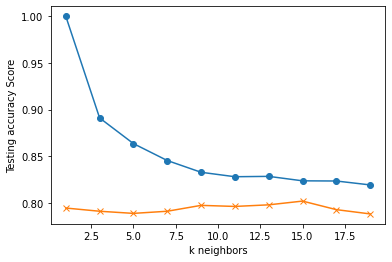

In [34]:
#Plot k values
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [35]:
# Use optimal k value to run kNN and score
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_minmax, y_train)
print('k=9 Test Acc: %.3f' % knn.score(X_test_minmax, y_test))

k=9 Test Acc: 0.797


## Hypertune the Model

In [36]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [37]:
from sklearn.model_selection import GridSearchCV
grid_params = {
    'n_neighbors': [3,5,7,9,11,19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

gs = GridSearchCV(KNeighborsClassifier(),grid_params, verbose = 1, cv=3,n_jobs=-1)
gs_results = gs.fit(X_train_minmax, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.0s finished


In [38]:
print(f"Best Parameters: {gs_results.best_params_}")
print(f"Best SVG score: {gs_results.best_score_}")

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best SVG score: 0.8020216197146509


### Create Hypertuned Model and Fit

In [39]:
knn2 = KNeighborsClassifier(metric='manhattan', weights='distance', n_neighbors=9)
knn2.fit(X_train_minmax, y_train)
print('Hypertuned kNN Test Acc: %.3f' % knn2.score(X_test_minmax, y_test))

Hypertuned kNN Test Acc: 0.810


### Save the Model

In [40]:
import joblib
filename = 'Models/lmstein_knn.sav'
joblib.dump("lmstein", filename)

['Models/lmstein_knn.sav']

# Neural Networks
-----

## Normal Neural Network

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Define number of inputs (features) and add to model
model=Sequential()
number_inputs = 18
number_hidden_nodes = 4
model.add(Dense(units=number_hidden_nodes,activation='relu', input_dim=number_inputs))

#Define number of output classes and add to model
number_classes = 3
model.add(Dense(units=number_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 76        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 15        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [42]:
#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
#Fit the model to training dataset
model.fit(
    X_train_minmax,
    y_train_categorical,
    epochs=100,
    shuffle=True,
    verbose=2
)

Train on 5243 samples
Epoch 1/100
5243/5243 - 1s - loss: 1.0455 - accuracy: 0.3221
Epoch 2/100
5243/5243 - 0s - loss: 0.8896 - accuracy: 0.5056
Epoch 3/100
5243/5243 - 0s - loss: 0.7419 - accuracy: 0.5295
Epoch 4/100
5243/5243 - 0s - loss: 0.6402 - accuracy: 0.7009
Epoch 5/100
5243/5243 - 0s - loss: 0.5757 - accuracy: 0.7370
Epoch 6/100
5243/5243 - 0s - loss: 0.5317 - accuracy: 0.7442
Epoch 7/100
5243/5243 - 0s - loss: 0.5015 - accuracy: 0.7448
Epoch 8/100
5243/5243 - 0s - loss: 0.4798 - accuracy: 0.7456
Epoch 9/100
5243/5243 - 0s - loss: 0.4638 - accuracy: 0.7461
Epoch 10/100
5243/5243 - 0s - loss: 0.4515 - accuracy: 0.7463
Epoch 11/100
5243/5243 - 0s - loss: 0.4417 - accuracy: 0.7475
Epoch 12/100
5243/5243 - 0s - loss: 0.4338 - accuracy: 0.7480
Epoch 13/100
5243/5243 - 0s - loss: 0.4273 - accuracy: 0.7496
Epoch 14/100
5243/5243 - 0s - loss: 0.4218 - accuracy: 0.7700
Epoch 15/100
5243/5243 - 0s - loss: 0.4169 - accuracy: 0.7778
Epoch 16/100
5243/5243 - 0s - loss: 0.4125 - accuracy: 0.

In [44]:
#Quantify the model
model_loss, model_accuracy = model.evaluate(
    X_test_minmax, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1748/1 - 0s - loss: 0.3559 - accuracy: 0.8049
Loss: 0.37313833539491387, Accuracy: 0.8049198985099792


## Deep Learning 

In [45]:
#Creat the model
deep_model = Sequential()
deep_model.add(Dense(units=6, activation='relu', input_dim=number_inputs))
deep_model.add(Dense(units=6, activation='relu'))
deep_model.add(Dense(units=number_classes, activation='softmax'))
deep_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6)                 114       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 21        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [46]:
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

deep_model.fit(
    X_train_minmax,
    y_train_categorical,
    epochs=100,
    shuffle=True,
    verbose=2
)

Train on 5243 samples
Epoch 1/100
5243/5243 - 1s - loss: 0.9560 - accuracy: 0.4566
Epoch 2/100
5243/5243 - 0s - loss: 0.6651 - accuracy: 0.6592
Epoch 3/100
5243/5243 - 0s - loss: 0.5166 - accuracy: 0.7521
Epoch 4/100
5243/5243 - 0s - loss: 0.4478 - accuracy: 0.7627
Epoch 5/100
5243/5243 - 0s - loss: 0.4121 - accuracy: 0.7784
Epoch 6/100
5243/5243 - 0s - loss: 0.3980 - accuracy: 0.7858
Epoch 7/100
5243/5243 - 0s - loss: 0.3904 - accuracy: 0.7854
Epoch 8/100
5243/5243 - 0s - loss: 0.3861 - accuracy: 0.7892
Epoch 9/100
5243/5243 - 0s - loss: 0.3827 - accuracy: 0.7862
Epoch 10/100
5243/5243 - 0s - loss: 0.3801 - accuracy: 0.7879
Epoch 11/100
5243/5243 - 0s - loss: 0.3784 - accuracy: 0.7915
Epoch 12/100
5243/5243 - 0s - loss: 0.3767 - accuracy: 0.7900
Epoch 13/100
5243/5243 - 0s - loss: 0.3753 - accuracy: 0.7864
Epoch 14/100
5243/5243 - 0s - loss: 0.3741 - accuracy: 0.7910
Epoch 15/100
5243/5243 - 0s - loss: 0.3733 - accuracy: 0.7883
Epoch 16/100
5243/5243 - 0s - loss: 0.3725 - accuracy: 0.

In [47]:
model_loss, model_accuracy = deep_model.evaluate(X_test_minmax, y_test_categorical, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

1748/1 - 0s - loss: 0.3475 - accuracy: 0.8169
Deep Neural Network - Loss: 0.36368869228002954, Accuracy: 0.8169336318969727
